# 元データの生成

$p(y|x)p(x)$の$p(x)$の部分

In [1]:
import autopep8
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

In [2]:
def gen_y(x):
    return -x + x**3 + np.random.normal(loc=0, scale=0.3, size=len(x))

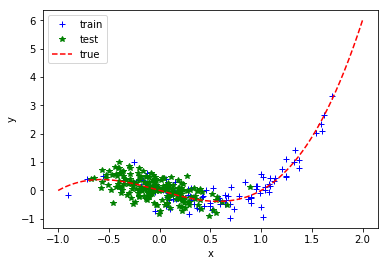

In [3]:
# Shimodaira et al. の設定
np.random.seed(123)
train_x = np.random.normal(loc=0.5, scale=0.5, size=100)
train_y = gen_y(train_x)
test_x = np.random.normal(loc=0, scale=0.3, size=200)
test_y = gen_y(test_x)

gri = np.linspace(-1, 2, 1000)
plt.plot(train_x, train_y, '+b', label='train')
plt.plot(test_x, test_y, '*g', label='test')
plt.plot(gri, -gri + gri**3, 'r--', label='true')
plt.xlabel('x')
plt.ylabel('y')
#plt.xlim(-1, 1.5)
#plt.ylim(-1, 1.5)
plt.legend()

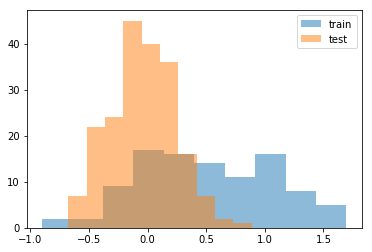

In [4]:
# データの密度
plt.hist(train_x, alpha=0.5, label='train')
plt.hist(test_x, alpha=0.5, label='test')
plt.legend()

# データ点間の距離計算

## 2つのデータセットが与えられた時に、行列で全組み合わせの距離を計算できるか
全組み合わせを作って行列計算を行おうとすると、$N(train num)\times M(test num)$の組み合わせをつくらなければいけないので、$1 \times M$の行列計算（距離行列）をN回行うことにする

In [5]:
np.random.seed(123)
x = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = 100)
y = np.random.multivariate_normal(mean = [1.5,1.5], cov = [[1,0],[0,1]], size = 100)

# CE最小化のためのデータ点重み付け
***注意事項***

エントロピー算出の際は, データ点間の距離に対してlogをとるので、1以下と1以上で挙動が変化するので注意が必要

→（1以上の距離になるように設定(距離尺度を変更)するか、　最大1の類似度になるように設計する必要がある）

In [6]:
## puriの重み
weight = np.zeros(len(x))

for i in range(len(x)):
    weight[i] = np.log(np.linalg.norm((np.copy(x[i,:]) - y), axis = 1)).sum()

inv_weight = 1/weight
weight = weight / weight.sum()

puriの初期値を$\frac{1}{n}$に設定して、最適化を行ってみる

In [7]:
grad = np.zeros(len(x))

for i in range(len(x)):
    grad[i] = np.log(np.linalg.norm((np.copy(x[i,:]) - y), axis = 1)).sum()


In [8]:
grad.max()

157.30488435820646

In [9]:
# 勾配が最も大きい軸を0に落とすための係数を求める
coef = 1/len(x)- grad / 1/len(x) / grad.max()
coef_scale = coef / coef.sum()
coef

array([0.00436549, 0.00269028, 0.00583364, 0.00088879, 0.00452437,
       0.00412281, 0.00511606, 0.00395107, 0.00784687, 0.00802058,
       0.00943523, 0.0048277 , 0.00237989, 0.00314895, 0.0035576 ,
       0.000379  , 0.00156926, 0.00648036, 0.00711104, 0.00424719,
       0.00145417, 0.00587917, 0.00629185, 0.00733259, 0.00876609,
       0.00183059, 0.00465603, 0.00770399, 0.00944855, 0.00985085,
       0.00513102, 0.00305815, 0.00934859, 0.00518689, 0.00345705,
       0.00424865, 0.0039474 , 0.00209785, 0.00460387, 0.00159234,
       0.00498796, 0.00923554, 0.00294219, 0.0022693 , 0.00705868,
       0.00355604, 0.00806339, 0.00663641, 0.00166507, 0.00530657,
       0.00201094, 0.00733118, 0.00570084, 0.00199475, 0.00258947,
       0.00638242, 0.00487471, 0.00777523, 0.00255669, 0.00197886,
       0.00398699, 0.00756115, 0.0061136 , 0.0081405 , 0.00492227,
       0.00211989, 0.00458745, 0.00771454, 0.00582948, 0.00590131,
       0.00416651, 0.00800017, 0.00601367, 0.00876153, 0.00548

Text(0.5,0,'weight')

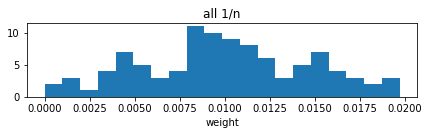

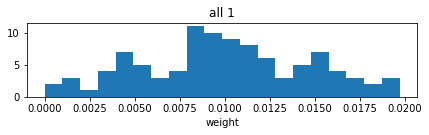

In [16]:
plt.figure(figsize = (7,3))
plt.subplot(2,1,1)
plt.hist(coef_scale, bins = 20)
plt.title('all 1/n')
plt.xlabel('weight')
plt.figure(figsize = (7,3))
plt.subplot(2,1,2)
plt.hist(op / op.sum(), bins = 20)
plt.title('all 1')
plt.xlabel('weight')

In [17]:
## どこかの重みが負になったら終了
for i in range(1000):
    if i  == 0:
        opt = 1- weight
        opt = opt / opt.sum()
        opt_pre = opt
        continue
    opt = opt_pre - weight * 0.001
    if np.sum(opt < 0) > 0:
        break
    opt = opt / opt.sum()
    opt_pre = opt
    
# つまりこういうこと？
# sum 1の平面に対する, 全重み1の地点からの射影

op = 1 - 1 / weight.max() * weight

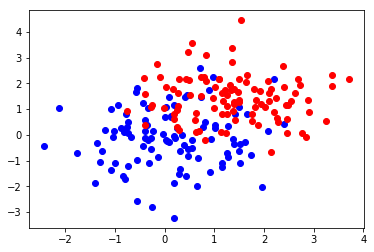

In [18]:
plt.plot(x[:,0], x[:,1], 'bo')
plt.plot(y[:,0], y[:,1], 'ro')

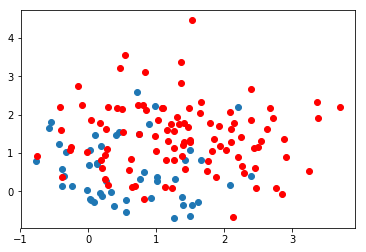

In [19]:
## puri後、topN個の重みのデータ
plt.plot(x[np.argsort(inv_weight,)[-50:]][:,0], x[np.argsort(inv_weight,)[-50:]][:,1], 'o')
plt.plot(y[:,0], y[:,1], 'ro')

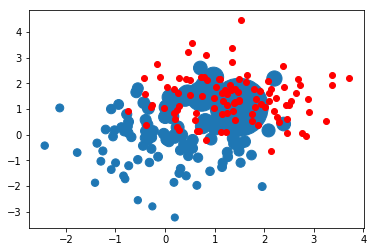

In [20]:
# 重みで大きさを表現したscatter
# 重みの逆数
plt.scatter(x[:,0], x[:,1],  s = inv_weight/inv_weight.min()*50)
plt.plot(y[:,0], y[:,1], 'ro')

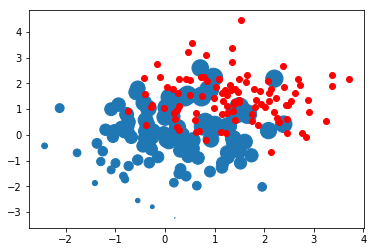

In [21]:
#勾配法(1つの重みを0にする最適化)による重み付
plt.scatter(x[:,0], x[:,1],  s = opt_pre/opt_pre.min()*0.3)
plt.plot(y[:,0], y[:,1], 'ro')

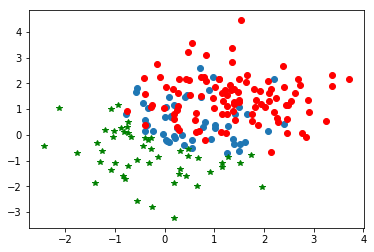

In [22]:
plt.plot(x[np.argsort(opt_pre,)[-50:]][:,0], x[np.argsort(opt_pre,)[-50:]][:,1], 'o')
plt.plot(y[:,0], y[:,1], 'ro')
plt.plot(x[np.argsort(opt_pre,)[:50]][:,0], x[np.argsort(opt_pre,)[:50]][:,1], 'g*')

(array([ 2.,  3.,  1.,  4.,  7.,  5.,  3.,  4., 11., 10.,  9.,  8.,  6.,
         3.,  5.,  7.,  4.,  3.,  2.,  3.]),
 array([0.        , 0.00098512, 0.00197025, 0.00295537, 0.00394049,
        0.00492561, 0.00591074, 0.00689586, 0.00788098, 0.00886611,
        0.00985123, 0.01083635, 0.01182148, 0.0128066 , 0.01379172,
        0.01477684, 0.01576197, 0.01674709, 0.01773221, 0.01871734,
        0.01970246]),
 <a list of 20 Patch objects>)

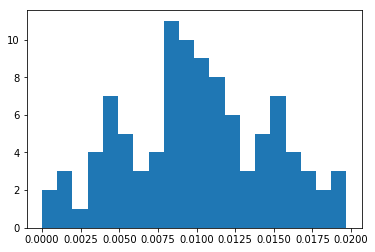

In [23]:
op = 1 - 1 / weight.max() * weight
plt.hist(op / op.sum(), bins = 20)

(array([ 3.,  2.,  3.,  4.,  7.,  5.,  3.,  6.,  8.,  9., 10., 11.,  4.,
         3.,  5.,  7.,  4.,  1.,  3.,  2.]),
 array([0.00029828, 0.00128333, 0.00226838, 0.00325343, 0.00423847,
        0.00522352, 0.00620857, 0.00719362, 0.00817866, 0.00916371,
        0.01014876, 0.01113381, 0.01211885, 0.0131039 , 0.01408895,
        0.015074  , 0.01605904, 0.01704409, 0.01802914, 0.01901419,
        0.01999924]),
 <a list of 20 Patch objects>)

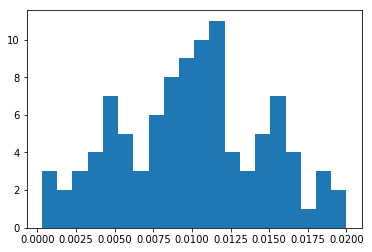

In [24]:
plt.hist(weight, bins = 20)

(array([ 2.,  3.,  1.,  4.,  7.,  5.,  3.,  4., 11., 10.,  9.,  8.,  6.,
         3.,  5.,  7.,  4.,  3.,  2.,  3.]),
 array([-4.12904763e-06,  9.80415547e-04,  1.96496014e-03,  2.94950474e-03,
         3.93404933e-03,  4.91859392e-03,  5.90313852e-03,  6.88768311e-03,
         7.87222771e-03,  8.85677230e-03,  9.84131690e-03,  1.08258615e-02,
         1.18104061e-02,  1.27949507e-02,  1.37794953e-02,  1.47640399e-02,
         1.57485845e-02,  1.67331291e-02,  1.77176737e-02,  1.87022182e-02,
         1.96867628e-02]),
 <a list of 20 Patch objects>)

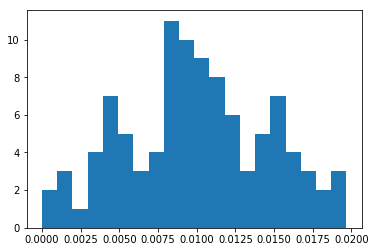

In [25]:
plt.hist(opt, bins = 20)

In [26]:
def cal_MCEW(train, test):
    # input object
    # train : numpy ndarray object asignned to weights
    # test : numpy ndarray object

    # return object
    # mcew : minimum cross entropy weight asign to train

    # 重みの初期化
    #weight = np.ones(len(train))
    # 微分係数の計算
    grad = np.zeros(len(train))
    if train.ndim > 1:
        for i in range(len(x)):
            grad[i] = np.log(np.linalg.norm(
                (np.copy(train[i, :]) - test), axis=1)).sum()
    else:
        for i in range(len(x)):
            grad[i] = np.log(np.abs((np.copy(train[i]) - test))).sum()
    grad = grad / grad.sum()

    # 初期値all 1時の最適な射影
    weight = 1 - 1 / grad.max() * grad
    return(weight / weight.sum())

In [27]:
def cal_MCEW2(train, test):
    ## input object
    # train : numpy ndarray object asignned to weights
    # test : numpy ndarray object
    
    ## return object
    # mcew : minimum cross entropy weight asign to train
    
    # 重みの初期化
    #weight = np.ones(len(train))
    # 微分係数の計算
    grad = np.zeros(len(train))
    if train.ndim > 1:
        for i in range(len(x)):
            grad[i] = np.log(np.linalg.norm((np.copy(train[i,:]) - test), axis = 1)).sum()
    else :
         for i in range(len(x)):
            grad[i] = np.log(np.abs((np.copy(train[i]) - test))).sum()
    grad = grad / grad.sum()
    
    # 初期値all 1時の最適な射影
    weight = 1 - 1 / grad.max() * grad
    return(weight / weight.sum())

## WLSによる回帰直線

In [28]:
import statsmodels.api as sm

In [29]:
train_x = sm.add_constant(train_x)
weight = cal_MCEW(train_x[:,1]*100, test_x*100)
wls_model = sm.WLS(list(train_y), train_x, weights = weight)
ols_model = sm.OLS(list(train_y), train_x)
res = wls_model.fit()
res_ols = ols_model.fit()
res.params

array([-0.03127288, -0.17382785])

In [30]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.031
Model:                            WLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.096
Date:                Wed, 11 Jul 2018   Prob (F-statistic):             0.0816
Time:                        15:25:34   Log-Likelihood:                -80.860
No. Observations:                 100   AIC:                             165.7
Df Residuals:                      98   BIC:                             170.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0313      0.046     -0.685      0.495      -0.122       0.059
x1            -0.1738      0.099     -1.759      0.082      -0.370       0.022
==============================================================================
Omnibus:                        0.467   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.154
Skew:                          -0.062   Prob(JB):                        0.926
Kurtosis:                       3.148   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     23.61
Date:                Wed, 11 Jul 2018   Prob (F-statistic):           4.48e-06
Time:                        15:25:35   Log-Likelihood:                -97.845
No. Observations:                 100   AIC:                             199.7
Df Residuals:                      98   BIC:                             204.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1755      0.088     -1.995      0.049      -0.350      -0.001
x1             0.5601      0.115      4.859      0.000       0.331       0.789
==============================================================================
Omnibus:                       25.364   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.727
Skew:                           1.122   Prob(JB):                     2.36e-09
Kurtosis:                       5.121   Cond. No.                         2.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

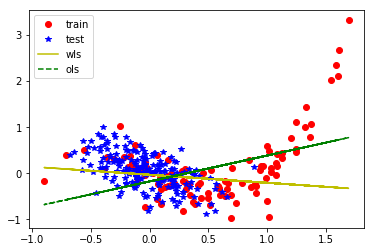

In [90]:
plt.plot(train_x[:,1], train_y, 'ro', label = 'train')
plt.plot(test_x, test_y, 'b*', label = 'test')
plt.plot(train_x[:,1], res.fittedvalues, 'y-',label = 'wls')
plt.plot(train_x[:,1], res_ols.fittedvalues,'g--',label = 'ols')
plt.legend(loc = 'best')
plt.savefig('res_wls.pdf')

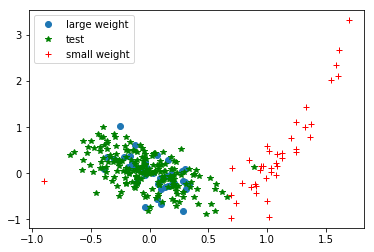

In [34]:
plt.plot(train_x[np.argsort(weight)[-40:],1],train_y[np.argsort(weight)[-40:]], 'o', label = 'large weight')
plt.plot(test_x, test_y,'*g', label = 'test')
plt.plot(train_x[np.argsort(weight)[:40],1],train_y[np.argsort(weight)[:40]], 'r+', label = 'small weight')
plt.legend()

## ３次曲線でのフィッティング
正直3次元だとあんまり変わらなす

In [ ]:
-x + x**3 + np.random.normal(loc=0, scale=0.3, size=len(x))

In [72]:
# numpy配列の結合の際にはbroadcastingが必要っぽ
train_x_3dim = np.concatenate((train_x, (np.zeros(100)[:, np.newaxis]), (train_x[:, 1]**3)[:, np.newaxis]), axis=1)

In [73]:
wls_model_3dim = sm.WLS(list(train_y), train_x_3dim, weights = weight)
ols_model_3dim = sm.OLS(list(train_y), train_x_3dim)
res_3dim = wls_model_3dim.fit()
res_ols_3dim = ols_model_3dim.fit()
res_3dim.params

array([ 0.0014203 , -1.06519122,  0.        ,  1.05628957])

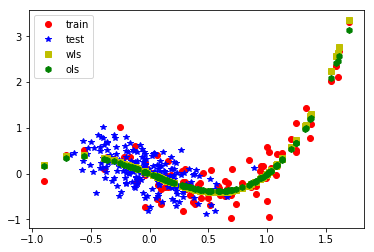

In [89]:
plt.plot(train_x_3dim[:,1], train_y, 'ro', label = 'train')
plt.plot(test_x, test_y, 'b*', label = 'test')
plt.plot(train_x_3dim[:,1], res_3dim.fittedvalues, 'ys',label = 'wls')
plt.plot(train_x_3dim[:,1], res_ols_3dim.fittedvalues,'gh',label = 'ols')
plt.legend(loc = 'best')
plt.savefig('res_wls_3dim.pdf')

In [87]:
res_3dim.params

array([ 0.0014203 , -1.06519122,  0.        ,  1.05628957])

In [88]:
res_ols_3dim.params

array([-0.00360347, -0.98429424,  0.        ,  0.98365565])